## Obtaining system's parameters with optics package

We are going to present two possible analysis to obtain the parameters of the **distance** between the two triangular prisms and the angle of the first prism (**alpha**) that we need to compute the theoretical transmission.

We are using here the `Monochromatic` class to read the experimental data and compute the transmittance, as we have explained previously in `hene-measurements.ipynb`. We are introducing now the classes from `analysis.py` that allow us to make the following analysis to provide the distance and the angle.

We will start the analysis by computing the distance between the prims using an optimization method. We will compare the relative angular distance from the experimental graph with the same relative distance from the theoretical graph.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from optics import Monochromatic, Angles, Maximums, Transmittance, Index

We will plot the experimental graph of the transmittance as a function of the internal angle, which we compute by using the `.int_angle()` method from the `Angles` class.

Critical angle: 41.315784°


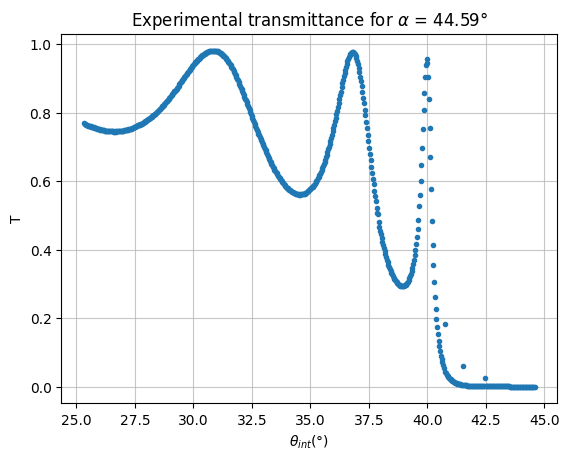

In [29]:
obj = Monochromatic('sources/set1')
obj._get_transmittance()

T_exp, theta_e = obj.data['a_r_TE']['T']['1']

theta_ext = theta_e * np.pi/180

alpha = 44.59090909090909 * np.pi/180 #test angle
wavelength = 0.6328 #HeNe wavelength

theta_int = Angles(alpha = alpha, wavelength = wavelength, theta_ext = theta_ext).int_angle() # [rad]
theta_c = Angles(alpha = alpha, wavelength = wavelength, theta_ext = theta_ext).int_critical_angle()

print('Critical angle: %2.6f°' % (theta_c*180/np.pi)) 

plt.figure()
plt.plot((theta_int*180/np.pi), T_exp, '.')
plt.grid(alpha = 0.7)
plt.title(r'Experimental transmittance for $\alpha$ = %2.2f°' % (alpha*180/np.pi) )
plt.xlabel(r'$\theta_{int} (°)$')
plt.ylabel('T')
plt.show()

As we can see we have three maximums, from which we can compute 2 relative angular distance that we are expecting to compare with the theoretical ones. Let's start by obtaining those relative distances. We will use now the `parabolic()` method from the `Maximums` class to obtain the maximum value by doing a parabolic adjustment.

In [30]:
values = [28.3, 35, 39.3, 41.7] #  best values to delimiter the maximums for this alpha 
maximums = []

for i in range(len(values)):
    try:
        _ , angle_1  = Maximums( T = T_exp).parabolic(angles = (theta_int*180/np.pi), 
                                                      value_1 = values[i],value_2 = values[i+1])

        if round(angle_1, 3) not in [round(val, 3) for val in maximums]: 
            maximums.append(angle_1)
    except Exception:
        break

relat_dist_exp = np.abs(np.diff(maximums)) #[°]

print('Maximum values:', maximums)
print('Relative distances:', relat_dist_exp)


Maximum values: [30.83681999697345, 36.79369298064401, 39.94301641607797]
Relative distances: [5.95687298 3.14932344]


We will now compare those relative distances with the same ones from the theoretical graph. We will do that for diferent values of the distance in order to find the one that provides the minimal difference, as follows:

In [31]:
d = np.linspace(1,3.5,100) * 10**(-6)  #we expect the distance to be near 3 um

min1 = 1000 ; min2 = 1000
possible_d_1 = [] ; possible_d_2 = []
min_vector_1 = [] ; min_vector_2 = []

for dist in d:

    T_teo = Transmittance(dist, alpha, theta_ext).transmittance() #we compute the theoretical transmittance for each value of d

    maximums = []
    for i in range(len(values)):
        try:
            _ , angle  = Maximums( T = T_teo).parabolic(angles = (theta_int*180/np.pi),
                                                        value_1 = values[i], value_2 = values[i+1])

            if round(angle, 3) not in [round(val, 3) for val in maximums]: 
                maximums.append(angle)
            
        except Exception:
            break
    
    # print('len max', len(maximums))

    relat_dist_teo = np.abs(np.diff(maximums)) #[°]

    min_vector_1.append(abs(relat_dist_exp[0] - relat_dist_teo[0]))
    min_vector_2.append(abs(relat_dist_exp[1] - relat_dist_teo[1]))

    if abs(relat_dist_exp[0] - relat_dist_teo[0]) < min1:
        min1 = abs(relat_dist_exp[0] - relat_dist_teo[0])
        final_d_1 = dist
    if abs(relat_dist_exp[1] - relat_dist_teo[1]) < min2:
        min2 = abs(relat_dist_exp[1] - relat_dist_teo[1])
        final_d_2 = dist

    else:
        continue

print('Final distances:', final_d_1 , final_d_2)


Final distances: 1.5050505050505051e-06 1.5555555555555556e-06


We will plot the values of the differences between both relative distances (the theoretical and the experimental ones) in order to see how it evolves with the different values of the distance.

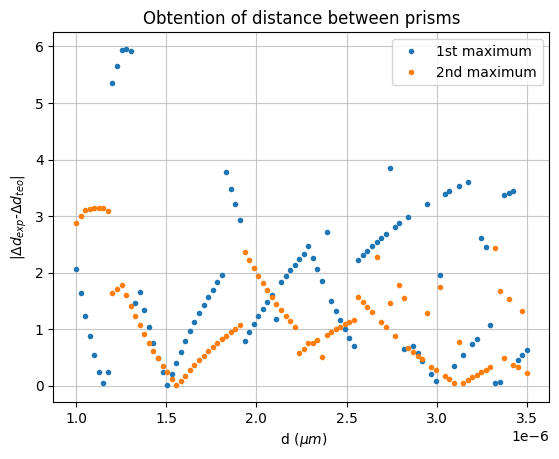

In [32]:
plt.figure()
plt.plot(d, min_vector_1,'.', label='1st maximum')
plt.plot(d, min_vector_2, '.', label = '2nd maximum')
plt.grid(alpha = 0.7)
plt.title(r'Obtention of distance between prisms' )
plt.xlabel(r' d ($\mu m$)')
plt.ylabel(r'|$\Delta d_{exp}$-$\Delta d_{teo}$|')
plt.legend(loc = 'best')
plt.show()

Finally, we will plot the experimental and the theoretical graphs together to see if that distance is adequate.

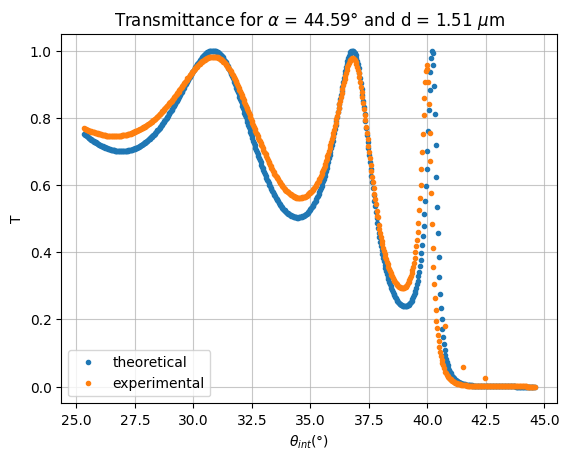

In [33]:
T_teo = Transmittance(final_d_1, alpha, theta_ext).transmittance()

plt.figure()
plt.plot((theta_int*180/np.pi), T_teo, '.', label='theoretical')
plt.plot((theta_int*180/np.pi), T_exp, '.', label = 'experimental')
plt.grid(alpha = 0.7)
plt.title(r'Transmittance for $\alpha$ = %2.2f° and d = %2.2f $\mu$m' % (alpha*180/np.pi,final_d_1*1e06) )
plt.xlabel(r'$\theta_{int} (°)$')
plt.legend(loc='best')
plt.ylabel('T')
plt.show()

You can find the code with everything we have just explained in `distance_optimization.py`

We will now compute the value of the angle *alpha* by using the optimization method. The procedure will be to compare the values of the angle *theta_int* associated to each maximum in order to find the angle *alpha* which best adjust both graphics.

In [34]:
# read experimental data

obj = Monochromatic('sources/set1')
obj._get_transmittance()

T_exp, theta_e = obj.data['a_r_TE']['T']['1']
theta_ext = theta_e * np.pi/180

wavelength = 0.6328
distance = 1.5050505050505051e-06 #arbitrary distance
alpha = 45 * np.pi/180 #arbitrary prism's angle to find maximums


theta_int = Angles(alpha = alpha, wavelength = wavelength, theta_ext = theta_ext).int_angle() # [rad]

We will now store the maximum values of the transmittance in order to find later the theta_int associated to that value. In this case we procedure in a different way because the values of the internal angle vary with the value of alpha and we have to take that into account when doing the optimization.

4
Maximum values of T for experimental graph: [0.9819476520588046, 0.9770539277525506, 0.9567843666285684]
Maximum indeces: [434, 243, 144]


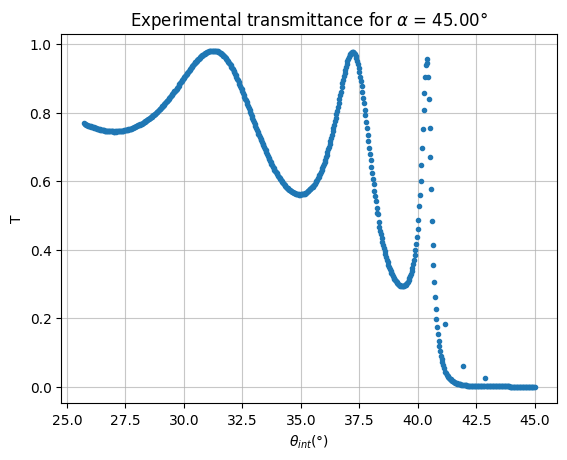

In [35]:
#we start by finding the experimental maximums

values = [27.3,35,39.3,41.7]

maximums = []
max_indexes = []
print(len(values))
for i in range(len(values)):
    try:
        obj_max_exp = Maximums( T = T_exp)
        T_max_exp , _  = obj_max_exp.interpolation(angles = (theta_int*180/np.pi), 
                                                    value_1 = values[i], value_2 = values[i+1])
        index = obj_max_exp.T_max_index
        if T_max_exp not in [val for val in maximums]: 
            maximums.append(T_max_exp)
        if index not in [val for val in max_indexes]:
            max_indexes.append(index)
    
    except Exception:
        break


print('Maximum values of T for experimental graph:', maximums)
print('Maximum indeces:', max_indexes)
    
plt.figure()
plt.plot((theta_int * 180/np.pi) ,T_exp,'.')
plt.grid(alpha=0.7)
plt.title(r'Experimental transmittance for $\alpha$ = %2.2f°' % (alpha*180/np.pi))
plt.xlabel(r'$\theta_{int} (°)$')
plt.ylabel('T')
plt.show()

4
Maximum values of T for theoretical graph: [0.999999999765731, 1.0000002262959349, 0.9999642577762263]


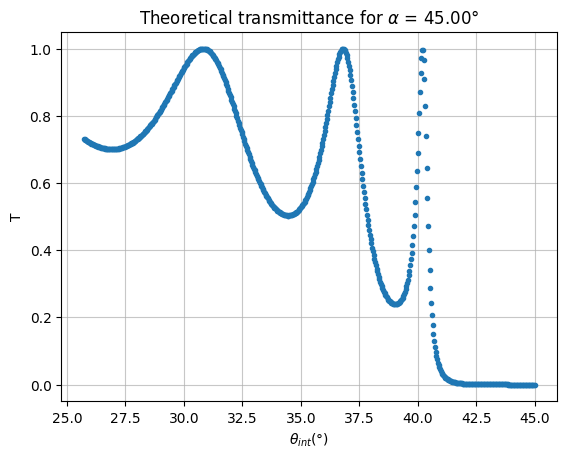

In [36]:
# we find now the theoretical maximums 

T_teo = Transmittance(distance, alpha, theta_ext).transmittance()

maximums_teo = []
print(len(values))
for i in range(len(values)):
    try:

        T_max_teo , _  = Maximums( T = T_teo).interpolation(angles = (theta_int*180/np.pi), 
                                                    value_1 = values[i], value_2 = values[i+1])
        if T_max_teo not in [val for val in maximums_teo]: 
            maximums_teo.append(T_max_teo)
    
    except Exception:
        break


print('Maximum values of T for theoretical graph:', maximums_teo)

plt.figure()
plt.plot((theta_int*180/np.pi), T_teo, '.')
plt.grid(alpha = 0.7)
plt.title(r'Theoretical transmittance for $\alpha$ = %2.2f°' % (alpha*180/np.pi) )
plt.xlabel(r'$\theta_{int} (°)$')
plt.ylabel('T')
plt.show()


Now we will compare the angles *theta_int* associated to each maximum in both the theoretical and the experimental graph in order to find the angle *alpha* that best adjust all the values.

In [37]:
a = np.linspace(44.5, 46, 100) * np.pi/180

min1 = 1000
min2 = 1000
min3 = 1000

for alpha in a:

    theta_int = Angles(alpha = alpha, wavelength = wavelength, 
                   theta_ext = theta_ext).int_angle() # [rad]
    i_1, i_2, i_3 = max_indexes
    i_1_exp = Index(T_exp).get_delimited_index(maximums[0], i_1)  #we get the index of the nearest element to maximums[0] in the region of the i_1 element
    i_2_exp =  Index(T_exp).get_delimited_index(maximums[1], i_2)
    i_3_exp =  Index(T_exp).get_delimited_index(maximums[2], i_3)

    angle_1_exp = (theta_int[i_1_exp]* 180/np.pi) #highest value of theta_int
    angle_2_exp = (theta_int[i_2_exp]* 180/np.pi)
    angle_3_exp = (theta_int[i_3_exp]* 180/np.pi)

    T_teo = Transmittance(distance, alpha, theta_ext).transmittance()

    i_1_teo, i_2_teo, i_3_teo = Index(T_teo).get_triple_index(maximums_teo[0])
    
    angle_1_teo = (theta_int[i_3_teo]* 180/np.pi) #highest value of theta_int
    angle_2_teo = (theta_int[i_2_teo]* 180/np.pi)
    angle_3_teo = (theta_int[i_1_teo]* 180/np.pi)

    if abs(angle_1_exp-angle_1_teo) < min1:
        final_a_1 = alpha
        min1 = abs(angle_1_exp-angle_1_teo)
    else:
        pass

    if abs(angle_2_exp-angle_2_teo) < min2:
        final_a_2 = alpha
        min2 = abs(angle_2_exp-angle_2_teo)
    else:
        pass

    if abs(angle_3_exp-angle_3_teo) < min3:
        final_a_3 = alpha
        min3 = abs(angle_3_exp-angle_3_teo)
    else:
        pass

print('Value of alpha by adjusting the 1st maximum:',final_a_1*180/np.pi)
print('Value of alpha by adjusting the 2nd maximum:',final_a_2*180/np.pi)
print('Value of alpha by adjusting the 3rd maximum:',final_a_3*180/np.pi)


Value of alpha by adjusting the 1st maximum: 44.59090909090909
Value of alpha by adjusting the 2nd maximum: 44.57575757575758
Value of alpha by adjusting the 3rd maximum: 44.81818181818182


We are now plotting together the experimental and theoretical graphs to see if they are adjusted.

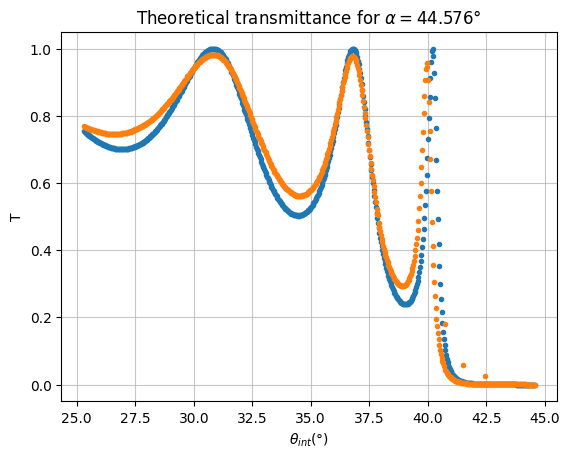

In [38]:
T_teo = Transmittance(distance, final_a_2, theta_ext).transmittance()
theta_int = Angles(alpha = final_a_2, wavelength = wavelength, theta_ext = theta_ext).int_angle() # [rad]

plt.figure()
plt.plot((theta_int*180/np.pi),T_teo,'.', label = 'teo')
plt.plot((theta_int*180/np.pi),T_exp,'.', label = 'exp')
plt.grid(alpha=0.7)
plt.title(r'Theoretical transmittance for $\alpha = %1.3f°$' % (final_a_2*180/np.pi))
plt.xlabel(r'$\theta_{int} (°)$')
plt.ylabel('T')
plt.show()

What we have just explained can be found uninterrumped at `angle_optimization.py`. It is good to remember here that alpha and the distance need to converge since both values are used to compute the other one, so it is a good practice to run both programs several times until we find its convergence.

We will now obtain the same parameters by using a correlation coefficient which allows us to obtain them in a simpler way. 

In [41]:
obj = Monochromatic('sources/set1')
obj._get_transmittance()

T_exp, theta_e = obj.data['a_r_TE']['T']['1']

theta_ext = theta_e * np.pi/180 #[rad]
alpha = 44.59090909090909 * np.pi/180
wavelength = 0.6328 #HeNe wavelength


theta_int = Angles(alpha = alpha, wavelength = wavelength, theta_ext = theta_ext).int_angle() # [rad]
theta_c = Angles(alpha = alpha, wavelength = wavelength, theta_ext = theta_ext).int_critical_angle()

distance = 1.5050505050505051e-06

T_teo = Transmittance(distance, alpha, theta_ext).transmittance()

Now we are comparing both the values of alpha and the distance together as follows:

In [42]:
num_points = 100
distance_values = np.linspace(1e-6, 3.5e-6, num_points)  
alpha_values = np.linspace(44, 46, num_points) * np.pi/180 

# Initialize variables to store the best parameters and correlation
best_distance = None
best_alpha = None
best_correlation = -1  # Initialize with a low value

for dist in distance_values:
    for a in alpha_values:
        # Calculate theoretical transmittance
        T_theoretical = Transmittance(dist, a, theta_ext).transmittance()

        # Calculate correlation coefficient
        correlation = np.corrcoef(T_theoretical, T_exp)[0, 1]

        # Update best parameters if the correlation is improved
        if correlation > best_correlation:
            best_correlation = correlation
            best_distance = distance
            best_alpha = alpha

print(f"Best Distance: {best_distance}")
print(f"Best Alpha: {best_alpha* 180/np.pi}")

Best Distance: 1.5050505050505051e-06
Best Alpha: 44.59090909090909


As we can see the values we are obtaining are what we expect from the optimization analysis. To finish, we will plot again the theoretical and experimental graphs to check that everything is correct.

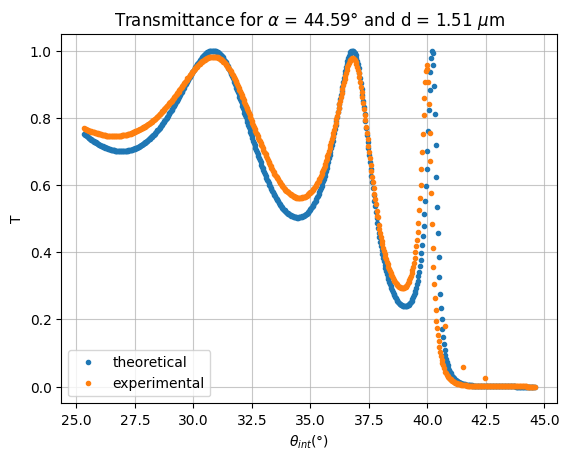

In [43]:
T_teo = Transmittance(best_distance, best_alpha, theta_ext).transmittance()
theta_int = Angles(alpha = best_alpha, wavelength = wavelength, theta_ext = theta_ext).int_angle() # [rad]


plt.figure()
plt.plot((theta_int*180/np.pi), T_teo, '.', label='theoretical')
plt.plot((theta_int*180/np.pi), T_exp, '.', label = 'experimental')
plt.grid(alpha = 0.7)
plt.title(r'Transmittance for $\alpha$ = %2.2f° and d = %2.2f $\mu$m' % (best_alpha*180/np.pi,best_distance*1e06) )
plt.xlabel(r'$\theta_{int} (°)$')
plt.legend(loc='best')
plt.ylabel('T')
plt.show()